In [7]:
import os
import glob
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# Define the path to the data_original folder
train_dir = Path('./data_raw_copy/train/images')
# train_dir = Path('./yolov8_proj_data/images/train/images')

def checkFiles(Filepath):
    # Check if the directory exists
    if not Filepath.exists():
        print(f"Directory {Filepath} does not exist!")
    else:
        # List all files in the directory
        list_Filepaths = list(Filepath.glob('*'))
        
        # Count files by extension
        extensions = {}
        for file in list_Filepaths:
            if file.is_file():
                ext = file.suffix.lower()
                if ext not in extensions:
                    extensions[ext] = 0
                extensions[ext] += 1
        
        # Print summary
        print(f"Found {len(list_Filepaths)} files in {Filepath}")
        print("\nFiles by extension:")
        for ext, count in extensions.items():
            print(f"{ext}: {count} files")
    
    return list_Filepaths

In [8]:
list_Filepaths = checkFiles(train_dir)
list_Labelpaths = checkFiles(Path('./data_original/train/labels'))

Found 500 files in data_raw_copy/train/images

Files by extension:
.jpg: 500 files
Found 500 files in data_original/train/labels

Files by extension:
.txt: 500 files


Open files: 249
Closed files: 251
Total files: 500
Open files: 49.8%
Closed files: 50.2%


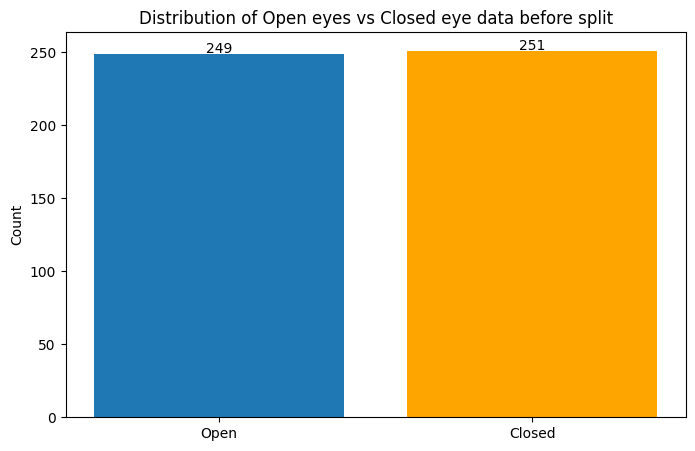

In [9]:
# Count open and closed files
open_files = [file for file in list_Filepaths if "open" in str(file).lower()]
closed_files = [file for file in list_Filepaths if "closed" in str(file).lower()]

# Print counts
print(f"Open files: {len(open_files)}")
print(f"Closed files: {len(closed_files)}")
print(f"Total files: {len(list_Filepaths)}")

# Optional: Show percentage
open_percentage = len(open_files) / len(list_Filepaths) * 100 if list_Filepaths else 0
closed_percentage = len(closed_files) / len(list_Filepaths) * 100 if list_Filepaths else 0
print(f"Open files: {open_percentage:.1f}%")
print(f"Closed files: {closed_percentage:.1f}%")

# Visualize the distribution
plt.figure(figsize=(8, 5))
counts = [len(open_files), len(closed_files)]
labels = ["Open", "Closed"]
colors = ['#1f77b4', 'orange']  # Blue for Open, Orange for Closed

plt.bar(labels, counts, color=colors)
plt.title("Distribution of Open eyes vs Closed eye data before split")
plt.ylabel("Count")

# Add count labels on top of bars
for i, v in enumerate(counts):
    plt.text(i, v + 0.5, str(v), ha='center')

plt.show()

Training files: 393 (78.6%)
Validation files: 57 (11.4%)
Test files: 50 (10.0%)


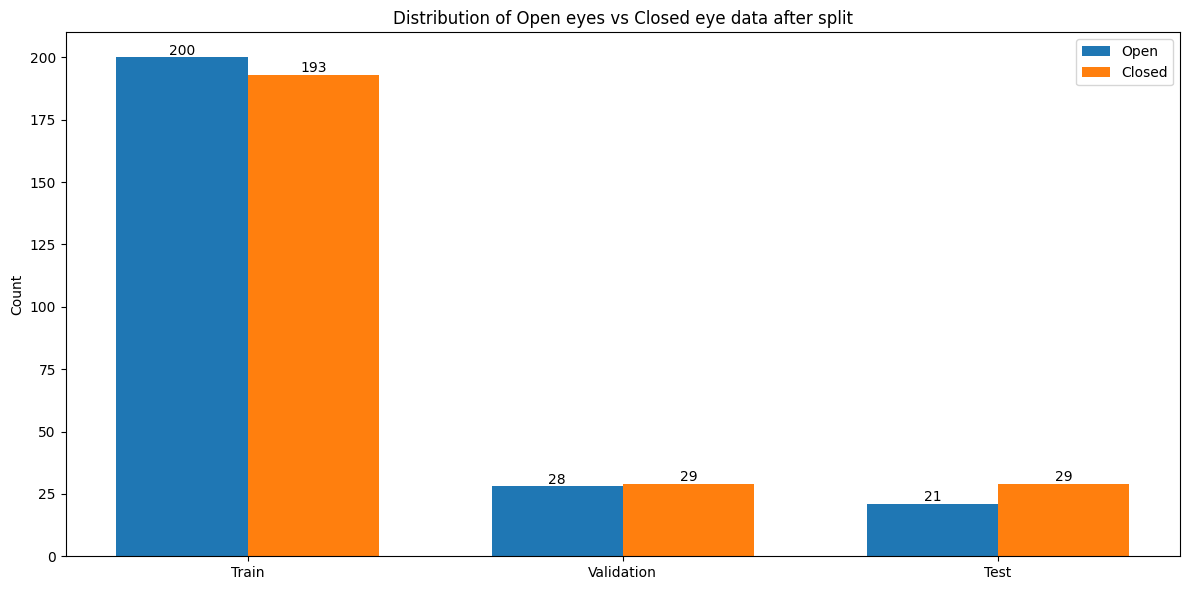

In [117]:
import numpy as np
from sklearn.model_selection import train_test_split

# First, split into train and temp (90/10)
train_files, test_files = train_test_split(list_Filepaths, test_size=0.1, random_state=42)

# Then split temp into val and test (50/50 of the 10% = 5% each of original)
train_files, val_files = train_test_split(train_files, test_size=0.125, random_state=42)  # 0.125 of 80% is 10% overall

# Check split sizes
print(f"Training files: {len(train_files)} ({len(train_files)/len(list_Filepaths)*100:.1f}%)")
print(f"Validation files: {len(val_files)} ({len(val_files)/len(list_Filepaths)*100:.1f}%)")
print(f"Test files: {len(test_files)} ({len(test_files)/len(list_Filepaths)*100:.1f}%)")

# Function to count open/closed files
def count_open_closed(files):
    open_count = sum(1 for file in files if "open" in str(file).lower())
    closed_count = sum(1 for file in files if "closed" in str(file).lower())
    return open_count, closed_count

# Count for each split
train_open, train_closed = count_open_closed(train_files)
val_open, val_closed = count_open_closed(val_files)
test_open, test_closed = count_open_closed(test_files)

# Create data for visualization
splits = ['Train', 'Validation', 'Test']
open_counts = [train_open, val_open, test_open]
closed_counts = [train_closed, val_closed, test_closed]

# Plot the distribution
plt.figure(figsize=(12, 6))

# Set width of bars
bar_width = 0.35
index = np.arange(len(splits))

# Create bars
plt.bar(index, open_counts, bar_width, label='Open')
plt.bar(index + bar_width, closed_counts, bar_width, label='Closed')

# Add labels and title
plt.ylabel('Count')
plt.title("Distribution of Open eyes vs Closed eye data after split")
plt.xticks(index + bar_width/2, splits)
plt.legend()

# Add count labels on top of bars
for i, v in enumerate(open_counts):
    plt.text(i, v + 1, str(v), ha='center')
    
for i, v in enumerate(closed_counts):
    plt.text(i + bar_width, v + 1, str(v), ha='center')

plt.tight_layout()
plt.show()

In [10]:
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

def display_image(image_path):
    """Display a single image"""
    # Read image
    img = cv2.imread(str(image_path))
    print(img.shape)
    # Convert from BGR to RGB (matplotlib uses RGB)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Display
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.title(f'Image: {image_path.name}')
    plt.axis('off')
    plt.show()



Example files:
- closed_-213-_jpg.rf.73123d4c57bc124d34ff0e66b554d043.jpg
(160, 160, 3)


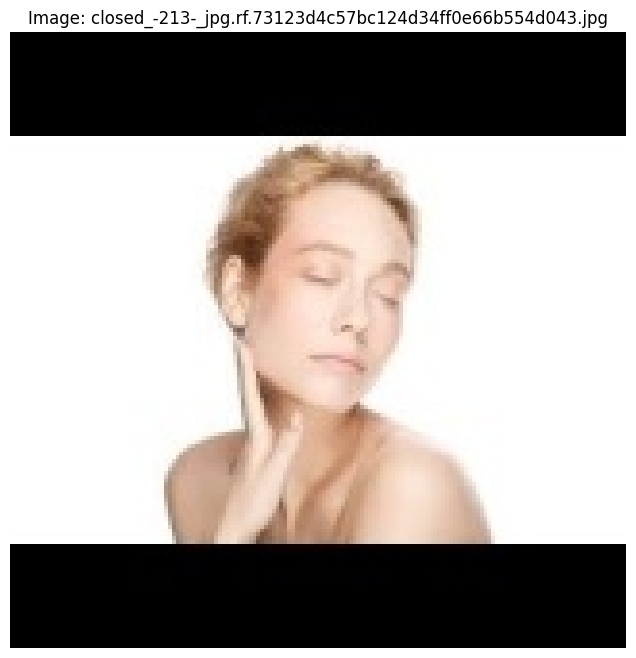

- open_-226-_jpg.rf.82aecf250a2a10525fba320b18a4c231.jpg
(160, 160, 3)


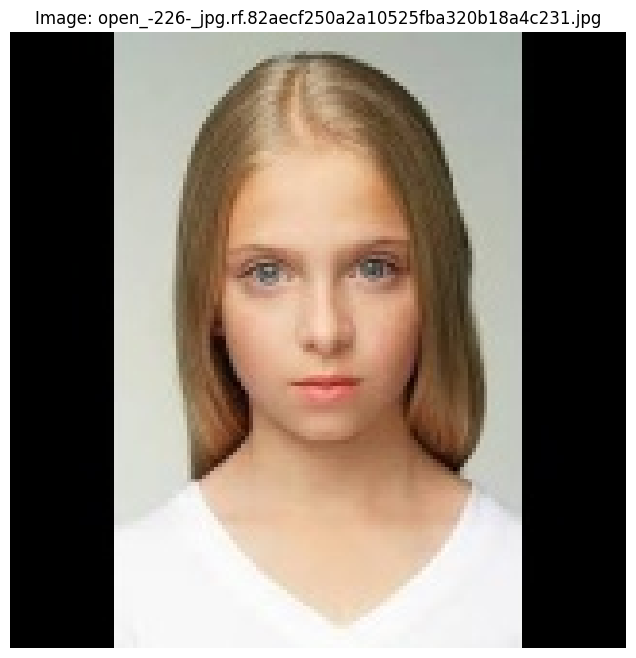

In [11]:
# Show a few example files
print("\nExample files:")
for file in list_Filepaths[:2]:
    print(f"- {file.name}")
    display_image(file)

In [12]:
def transform_bounding_boxes(boxes, original_size, new_size, scale, offsets):
    """
    Transform YOLO format bounding boxes when resizing with letterboxing
    
    Parameters:
    -----------
    boxes : list
        List of YOLO format bounding boxes [class_id, x_center, y_center, width, height]
    original_size : tuple
        Original image size (width, height)
    new_size : int
        New square image size (both width and height)
    scale : float
        Scale factor used for resizing
    offsets : tuple
        (x_offset, y_offset) used for centering the image on the canvas
    
    Returns:
    --------
    list
        Transformed bounding boxes in YOLO format
    """
    orig_w, orig_h = original_size
    x_offset, y_offset = offsets
    transformed_boxes = []
    
    for box in boxes:
        class_id, x_center, y_center, width, height = box
        
        # Scale coordinates (apply the same scale factor as the image)
        x_center_scaled = x_center * scale
        y_center_scaled = y_center * scale
        width_scaled = width * scale
        height_scaled = height * scale
        
        # Apply offset (accounting for the padding)
        # First convert from normalized to absolute coordinates
        x_center_abs = x_center_scaled * orig_w
        y_center_abs = y_center_scaled * orig_h
        width_abs = width_scaled * orig_w
        height_abs = height_scaled * orig_h
        
        # Add offset
        x_center_final = (x_center_abs + x_offset) / new_size
        y_center_final = (y_center_abs + y_offset) / new_size
        width_final = width_abs / new_size
        height_final = height_abs / new_size
        
        transformed_boxes.append([class_id, x_center_final, y_center_final, width_final, height_final])
    
    return transformed_boxes

Original: 183x275
(106, 160)
Square with padding: (160, 160)


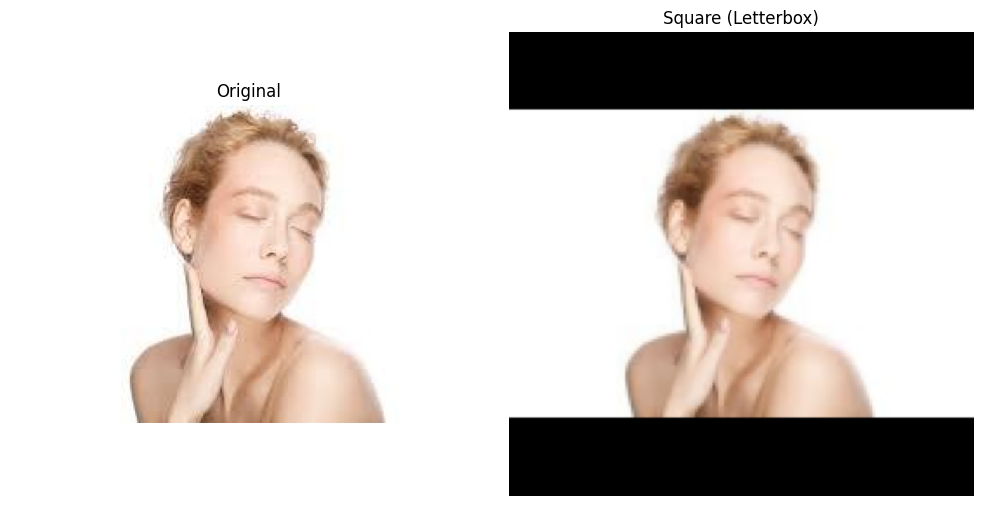

Original: 275x183
(160, 106)
Square with padding: (160, 160)


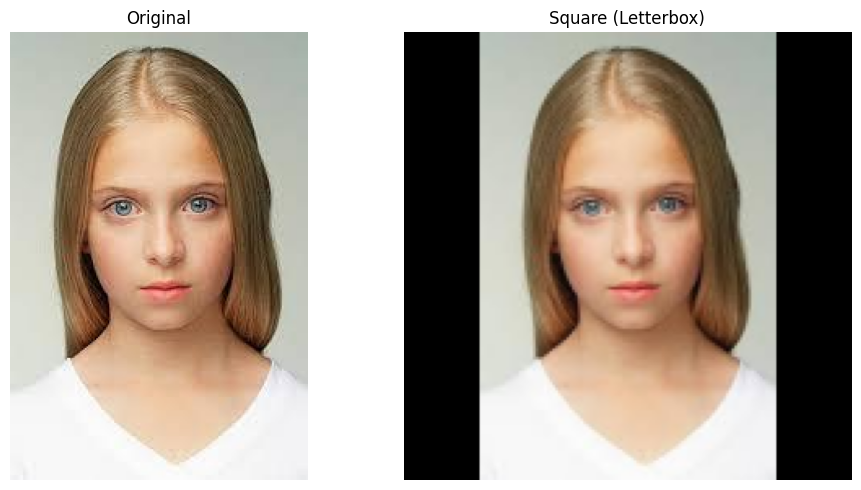

In [72]:
for file in list_Filepaths[:2]:
    # Read image
    img = cv2.imread(str(file))
    (h, w) = img.shape[:2]
    print(f"Original: {h}x{w}")
    
    # Resize with padding (letterbox)
    new_dim = 160
    
    # Create a square black image
    square_img = np.zeros((new_dim, new_dim, 3), dtype=np.uint8)
    
    # Calculate scaling factor to maintain aspect ratio
    scale = min(new_dim/w, new_dim/h)
    
    # Calculate new dimensions
    new_w = int(w * scale)
    new_h = int(h * scale)
    
    # Resize image
    resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)

    print(resized.shape[:2])
    
    # Calculate position to paste (center)
    x_offset = (new_dim - new_w) // 2
    y_offset = (new_dim - new_h) // 2
    
    # Paste resized image onto square canvas
    square_img[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized
    
    print(f"Square with padding: {square_img.shape[:2]}")

    # Normalize for display only
    img_norm = img.astype(float) / 255.0
    square_img_norm = square_img.astype(float) / 255.0
    
    # Display images
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Original')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(square_img, cv2.COLOR_BGR2RGB))
    plt.title('Square (Letterbox)')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [13]:
def reshapeImageAndBox(list_Filepaths):
    for file in list_Filepaths:
        # Read image
        img = cv2.imread(str(file))
        (h, w) = img.shape[:2]
        print(f"Original: {h}x{w}")
        
        # Get corresponding label file (assuming it's in a 'labels' directory)
        label_path = str(file).replace('images', 'labels').replace('.jpg', '.txt')
        
        # Read YOLO format labels (class_id, x_center, y_center, width, height)
        boxes = []
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f.readlines():
                    values = line.strip().split()
                    if len(values) == 5:  # class_id, x_center, y_center, width, height
                        boxes.append([int(values[0])] + [float(v) for v in values[1:]])
                        
        # Resize with padding (letterbox)
        new_dim = 160
        
        # Create a square black image
        square_img = np.zeros((new_dim, new_dim, 3), dtype=np.uint8)
        
        # Calculate scaling factor to maintain aspect ratio
        scale = min(new_dim/w, new_dim/h)
        
        # Calculate new dimensions
        new_w = int(w * scale)
        new_h = int(h * scale)

        print(f"Resized: {new_h}x{new_w}")

        
        # Resize image
        resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
        
        # Calculate position to paste (center)
        x_offset = (new_dim - new_w) // 2
        y_offset = (new_dim - new_h) // 2
        
        # Paste resized image onto square canvas
        square_img[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized
        
        # Transform bounding boxes
        transformed_boxes = transform_bounding_boxes(
            boxes, 
            (w, h), 
            new_dim, 
            scale, 
            (x_offset, y_offset)
        )
        
        # Display images with bounding boxes
        plt.figure(figsize=(10, 5))
        
        # Original image with boxes
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        for box in boxes:
            class_id, x_center, y_center, width, height = box
            x1 = int((x_center - width/2) * w)
            y1 = int((y_center - height/2) * h)
            x2 = int((x_center + width/2) * w)
            y2 = int((y_center + height/2) * h)
            plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, 
                                            fill=False, edgecolor='red', linewidth=2))
        plt.axis('off')
        
        # Resized image with boxes
        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(square_img, cv2.COLOR_BGR2RGB))
        for box in transformed_boxes:
            class_id, x_center, y_center, width, height = box
            x1 = int((x_center - width/2) * new_dim)
            y1 = int((y_center - height/2) * new_dim)
            x2 = int((x_center + width/2) * new_dim)
            y2 = int((y_center + height/2) * new_dim)
            plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, 
                                            fill=False, edgecolor='red', linewidth=2))
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()

        # Save transformed image and labels
        output_img_path = str(file).replace('original', 'processed')
        output_label_path = label_path.replace('original', 'processed')
        cv2.imwrite(output_img_path, square_img)
        with open(output_label_path, 'w') as f:
            for box in transformed_boxes:
                line = ' '.join([str(box[0])] + [f"{v:.6f}" for v in box[1:]])
                f.write(line + '\n')

Original: 160x160
Resized: 160x160


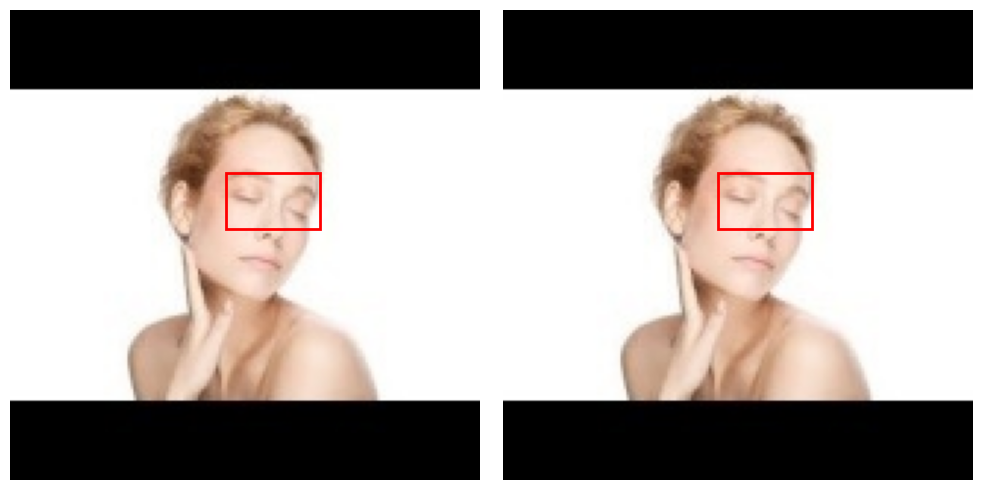

Original: 160x160
Resized: 160x160


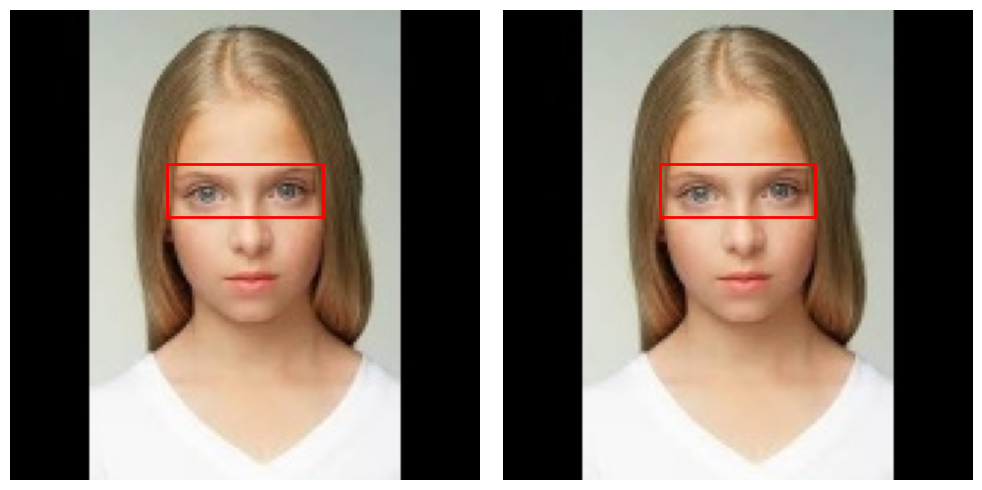

Original: 160x160
Resized: 160x160


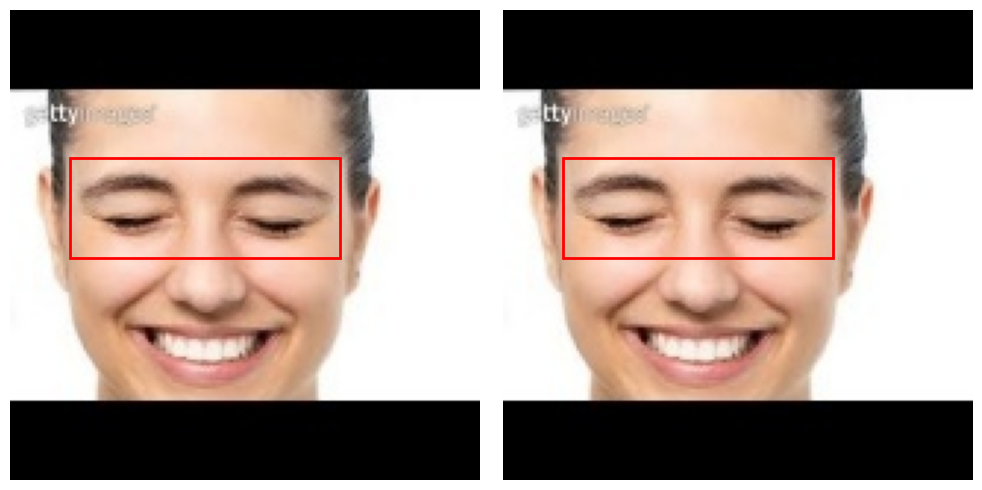

In [15]:
reshapeImageAndBox(list_Filepaths[:3])

In [2]:
custom_dataPath = Path('custom_data/images')

list_customData = checkFiles(custom_dataPath)

# print("\nExample files:")
# for file in list_customData:
#     if file.name.endswith('.jpg'):
#         print(f"- {file.name}")
#         display_image(file)

display_image(list_customData[5])


NameError: name 'Path' is not defined

Original: 1080x1920
(90, 160)
Square with padding: (160, 160)


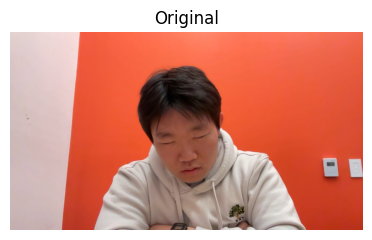

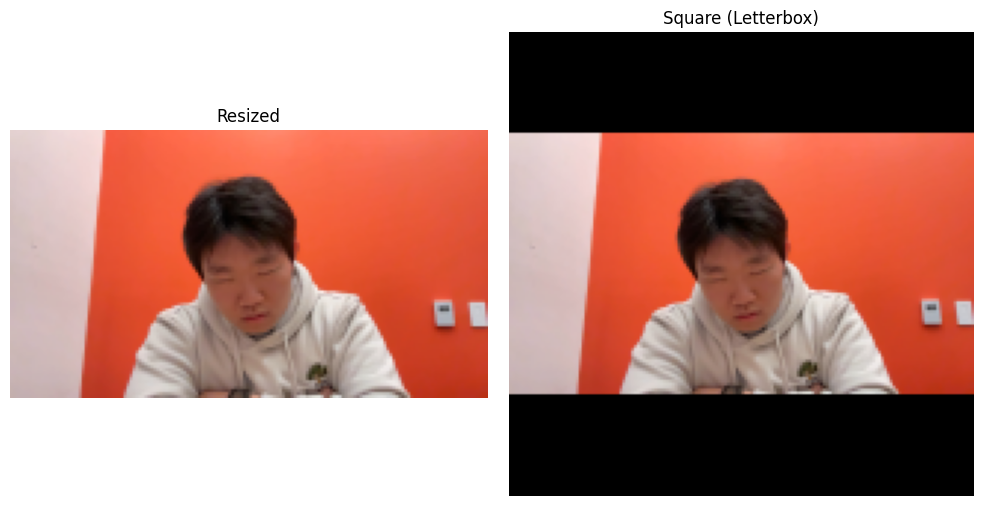

In [131]:
# Read image
img = cv2.imread(str(list_customData[5]))
(h, w) = img.shape[:2]
print(f"Original: {h}x{w}")

# Resize with padding (letterbox)
new_dim = 160

# Create a square black image
square_img = np.zeros((new_dim, new_dim, 3), dtype=np.uint8)

# Calculate scaling factor to maintain aspect ratio
scale = min(new_dim/w, new_dim/h)

# Calculate new dimensions
new_w = int(w * scale)
new_h = int(h * scale)

# Resize image
resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)

print(resized.shape[:2])

# Calculate position to paste (center)
x_offset = (new_dim - new_w) // 2
y_offset = (new_dim - new_h) // 2

# # Paste resized image onto square canvas
square_img[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized

print(f"Square with padding: {square_img.shape[:2]}")

# Normalize for display only
img_norm = img.astype(float) / 255.0
square_img_norm = square_img.astype(float) / 255.0

# Display images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original')
plt.axis('off')

# Display images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(resized, cv2.COLOR_BGR2RGB))
plt.title('Resized')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(square_img, cv2.COLOR_BGR2RGB))
plt.title('Square (Letterbox)')
plt.axis('off')

plt.tight_layout()
plt.show()